In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import trainer
from trainer import device

In [4]:
import re

In [5]:
# load dictionary (100k words) from /usr/share/dict/words
with open('/usr/share/dict/words', 'r') as f:
    vocab = {}
    for line in f:
        word = line.strip().replace("'","").lower()
        if not word in vocab:
            vocab[word] = len(vocab)

words = sorted(vocab.keys(), key=lambda w: vocab[w])

assert(len(words) == len(vocab))
assert(vocab[words[42]] == 42)

In [6]:
# given a sentence, generate skip-gram pairs of words as indices
phrase_re = re.compile(r'[!.;()"\']+')
word_re = re.compile(r'[,\s-]+')

def sentences(str):
    return [[w.lower() for w in word_re.split(p) if len(w) > 0] for p in phrase_re.split(str.lower())]

def skipgrams(str, n=2):
    r = []
    for p in sentences(str):
        ws = [vocab[w] for w in p if w in vocab]
        for i, w in enumerate(ws):
            for j in range(i-n, i+n+1):
                if j >= 0 and j < len(ws) and j != i:
                    r.append((ws[i], ws[j]))
    return r

In [7]:
import random
import os.path

# given a file, endlessly produce skipgrams from random offsets
class SkipgramDataset(D.IterableDataset):
    def __init__(self, path, n=2):
        super().__init__()
        self.file = open(path, 'r', errors='ignore')
        self.size = os.path.getsize(path)
        self.n = n
    def __iter__(self):
        block_size = 1024
        while True:
            offset = random.randrange(self.size - block_size)
            self.file.seek(offset, 0)
            block = self.file.read(block_size)
            for x, y in skipgrams(block, self.n):
                yield x, y

In [8]:
# word2vec network
# trains ~30s/batch (batch size 256, optimizer adamw)
class Word2Vec(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.u = nn.Linear(len(vocab), n_hidden, bias=False)
        self.v = nn.Linear(n_hidden, len(vocab), bias=False)
        
    def forward(self, x):
        x = F.one_hot(x, len(vocab)).float()
        return self.v(self.u(x))
    
    def loss(self, p, y):
        return F.cross_entropy(p, y)
    
    @torch.no_grad()
    def weights(self):
        return (self.u.weight.data.T + self.v.weight.data).detach()

In [9]:
# word2vec network using embedding and negative sampling
# trains ~23s/batch (batch size 256, optimizer adamw)
class Word2VecEmb(nn.Module):
    def __init__(self, n_hidden, n_k=10):
        super().__init__()
        self.u = nn.Embedding(len(vocab), n_hidden)
        self.v = nn.Embedding(len(vocab), n_hidden)
        self.n_k = n_k

        wr = len(vocab)**-0.5
        torch.nn.init.normal_(self.u.weight.data, 0, wr)
        torch.nn.init.normal_(self.v.weight.data, 0, wr)

    def forward(self, x):
        return self.u(x)
    
    def loss(self, p, y):
        B = y.shape[0]
        # ideally this should be weighted by word probability instead of being uniform
        ny = torch.randint(len(vocab), (self.n_k, B), device=y.device)
        lp = (p * self.v(y)).sum(1) # B
        ln = (p * self.v(ny)).sum(2) # KxB
        return -(F.logsigmoid(lp).sum() + F.logsigmoid(-ln).sum() / self.n_k) / B
    
    @torch.no_grad()
    def weights(self):
        return (self.u.weight.data + self.v.weight.data).detach()

Train [45.238M params]: 1000 epochs took 11151.37 sec, train loss 0.352808, val loss 0.000000


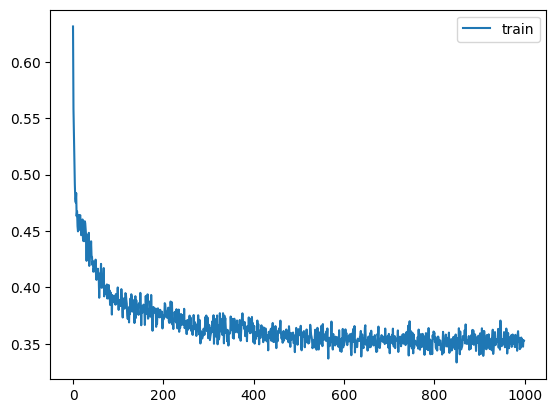

In [10]:
net = Word2VecEmb(256).to(device)
data = D.DataLoader(SkipgramDataset("../gutenberg.txt", n=3), batch_size=256, num_workers=6)
trainer.train(net, data, batch_limit=1000, epochs=1000)

In [16]:
netw = net.weights()

In [17]:
def encode(w):
    return netw[vocab[w]]

def dist(w1, w2):
    v1 = encode(w1)
    v2 = encode(w2)
    return torch.sqrt(((v1 - v2)**2).sum()).item()

def decode(v, k=3):
    d = netw - torch.unsqueeze(v, 0)
    l2 = (d * d).sum(1)
    tk = torch.topk(l2, k, largest=False).indices
    return [(words[i], l2[i].item()) for i in tk]

In [18]:
decode(encode("man") - encode("woman") + encode("her"))

[('his', 24.02366828918457),
 ('he', 30.355552673339844),
 ('her', 31.553482055664062)]

In [20]:
countries = ["china", "russia", "japan", "turkey", "poland", "germany", "france", "italy", "greece", "spain", "portugal"]
capitals = ["beijing", "moscow", "tokyo", "ankara", "warsaw", "berlin", "paris", "rome", "athens", "madrid", "lisbon"]

capital_of = torch.sum(torch.stack([encode(ca) - encode(co) for ca,co in zip(capitals, countries)]), 0) / len(capitals)

decode(capital_of + encode("russia"))

[('czar', 5.425647735595703),
 ('moscow', 5.621978759765625),
 ('viceroy', 6.0333051681518555)]